# Prolexitim NLP Analytics
## Predicting TAS-20 from subject text
### Using OpenAI API for embeddings and GPT-based approaches
<hr>

- Prolexitim normalized dataset version Jan23 (from Psicobotica citizen science forms).
- Dataset from Piscobotica Prolexitim TAS-20 Spain instrument and Prolexitim NLP.
- Updated Jan '23, including automated English translation of users' inputs. 

<hr>
Raúl Arrabales Moreno - Updated 4th May 2023 (Psicobótica)<br>

- [conscious-robots.com](http://www.conscious-robots.com/)
- [psicobotica.com](http://www.psicobotica.com/en/)

<hr>

#### This notebook contains:
- Prolexitim dataset loading and checking
- Obtaining OpenAI ADA Embeddings for Card1
- 


### Helper functions

In [10]:
def get_apikey_from_file(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

### Loading Prolexitim Dataset

In [36]:
import pandas as pd 
import numpy as np

prolexitim_dataset_path = "data/Prolexitim_Jan23_En.csv"
prolexitim_df = pd.read_csv(prolexitim_dataset_path,header=0,delimiter=",")

In [3]:
prolexitim_df.sample(5)

,Timestamp,TAS20,F1,F2,F3,Gender,Age,Code,Alexithymia,Timestamp (1),...,Depression,BAI,Anxiety,PSS,AN,AP,Text_Card1_en,Text_Card9VH_en,Text_Card11_en,Text_Card13HM_en
167,2021-03-02T15:18:19.781Z,77,31,21,25,2,31,20850840d662dd622d0954cc665ac1fa,POSITIVE,2021-03-02T15:23:36.144Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,... The boy doesn't want to play the violin,... The men on the battlefield are dead,...There is a vulture on a rocky cliff waiting...,... The man killed the woman unintentionally a...
908,2022-04-26T04:01:09.648Z,75,30,22,23,2,20,85440806db36c87d4e5ff39351a67702,POSITIVE,2022-04-26T04:10:36.656Z,...,POSITIVE,47.0,POSITIVE,34.0,NaN,NaN,"That is, without a doubt, the disappointed loo...",The day had been exhausting for all the worker...,The war is over and all that remains are the r...,Along with the night came the departure of the...
998,2022-11-06T04:05:15.752Z,77,29,20,28,2,18,6a554e43beb267376f3ee3c98df3d6e5,POSITIVE,2022-11-06T04:09:15.529Z,...,POSITIVE,41.0,POSITIVE,42.0,30.0,17.0,...\nA boy who was forced to study hard and pl...,...\nAn invasion of rats in which people had t...,"...\nA jungle, a bird on the edge of a cliff w...","...\nA married couple in the morning, the man ..."
694,2021-10-03T19:32:30.266Z,91,34,25,32,2,18,236a07c3853c6e68c9fc08e35f0cf179,POSITIVE,2021-10-03T19:47:40.631Z,...,POSITIVE,NaN,UNKNOWN,49.0,22.0,28.0,"...\na boy wanted to be a violinist, he always...","... a man was surrounded by his best friends, ...",...a bored girl from her family went to the mo...,"... a man, he thought he was in love, but he w..."
448,2021-05-17T07:07:57.660Z,71,22,24,25,2,20,20e00639682765451f9b709a9ebeb4f8,POSITIVE,2021-05-17T07:33:41.708Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,Once upon a time there was a boy who wanted to...,Many men in war enjoy a moment of peace sleepi...,The waterfall of the nymph where she had her h...,This man is cheating on his wife for a long ti...


In [4]:
prolexitim_df.columns

Index(['Timestamp', 'TAS20', 'F1', 'F2', 'F3', 'Gender', 'Age', 'Code',
       'Alexithymia', 'Timestamp (1)', 'DateDiff_TAS20_NLP', 'Text_Card1',
       'Text_Card9VH', 'Text_Card11', 'Text_Card13HM', 'Text_AllCards', 'PHQ9',
       'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'Depression',
       'BAI', 'Anxiety', 'PSS', 'AN', 'AP', 'Text_Card1_en', 'Text_Card9VH_en',
       'Text_Card11_en', 'Text_Card13HM_en'],
      dtype='object')

In [5]:
# Reduced dataset for alexithymia binary classification (Spanish)
alex_bin_es_df = prolexitim_df[['Code','Alexithymia',
                                'Text_Card1','Text_Card9VH', 
                                'Text_Card11', 'Text_Card13HM', 
                                'Text_AllCards']]

In [6]:
alex_bin_es_df.sample(5)

,Code,Alexithymia,Text_Card1,Text_Card9VH,Text_Card11,Text_Card13HM,Text_AllCards
971,66f49551884b2adcbe9d05e3738d8450,POSITIVE,... \nUn niño sentado en su banco de estudio....,... \nUn grupo de trabajadores aprovechando s...,... \nUn camino de tierra que te lleva a una ...,... \nUn hombre despidiendo a su esposa despu...,... \nUn niño sentado en su banco de estudio....
989,da8c3d15e1caab6a2f4aa4e4bdca9ad3,POSITIVE,... Un chico que tenía una pasión por el viol...,... \nUn grupo de hombres que eran amigos de ...,... Existió el camino que decían que quitaba ...,un hombre con problemas de ira estaba tratand...,... Un chico que tenía una pasión por el viol...
720,7c2d4a539b7d771671ef745f6558fa4c,POSITIVE,"Había una vez un niño que tenía un sueño, quer...","Un grupo de amigos ivivían en un pueblo, había...","\nNo logro distinguir nada de la imagen, así q...",Había un hombre que era muy borracho y mujerie...,"Había una vez un niño que tenía un sueño, quer..."
521,a5f4f654a0739ba30a1146b5b014a617,POSITIVE,... \nUn niño que estaba frustrado por no sab...,... \nUn soldado dormido junto a sus amigos d...,... \nUna cascada muy bonita,... \nUn hombre que estaba triste por haber a...,... \nUn niño que estaba frustrado por no sab...
613,e716902c617896d0126bca315905483b,POSITIVE,... \nerase una vez un niño que le gustaba mu...,... \nunos hombres que estaban exhaustos de t...,... no logró identificar para nada la imagen\n,... \nUn hombre tiene que ir a trabajar despu...,... \nerase una vez un niño que le gustaba mu...


In [9]:
# It's quite unbalanced (Let's keep it that way for the time being)
alex_bin_es_df.value_counts('Alexithymia')

Alexithymia
POSITIVE    781
NEGATIVE    230
Name: count, dtype: int64

### Build OpenAI Embeddings

In [15]:
# My OpenIA API Key
import openai
import os

os.environ["OPENAI_API_KEY"] = get_apikey_from_file('ram_openai_apikey.txt')

In [13]:
# Using the text-embedding-ada-002 model
# See: https://openai.com/blog/new-and-improved-embedding-model

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [26]:
# Delayed call to prevent this error:
# RateLimitError: Rate limit reached for default-global-with-image-limits in organization on requests per min. 
# Limit: 60 / min. Please try again in 1s. Contact us through our help center at help.openai.com if you continue to have issues. 
import time

def delayed_get_embedding(text, model, delay=1.0):
    time.sleep(delay)
    return get_embedding(text, model)

In [18]:
# Test the API
embed1 = get_embedding('Prueba de texto número uno')
embed1[0:5]

[-0.010036744177341461,
 -0.006101734936237335,
 -0.0021321496460586786,
 0.0005581457517109811,
 0.003024524310603738]

In [28]:
# Test the delayed API +call
embed2 = delayed_get_embedding('Prueba de texto número dos con retardo','text-embedding-ada-002', 0.1)
embed2[0:5]

[-0.03275999426841736,
 -0.013665752485394478,
 -0.009965736418962479,
 0.006113803945481777,
 0.004797192290425301]

In [31]:
# Adding the ADA embedding for Card1 text (one per second)
alex_bin_es_df['ada_card1'] = alex_bin_es_df['Text_Card1'].apply(lambda x: delayed_get_embedding(x, model='text-embedding-ada-002',delay=1.0))

/tmp/ipykernel_22351/3072694236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alex_bin_es_df['ada_card1'] = alex_bin_es_df['Text_Card1'].apply(lambda x: delayed_get_embedding(x, model='text-embedding-ada-002',delay=1.0))


In [32]:
alex_bin_es_df.sample(5)

,Code,Alexithymia,Text_Card1,Text_Card9VH,Text_Card11,Text_Card13HM,Text_AllCards,ada_card1
68,1e72525d8fb4f267c045e14d55640ad4,POSITIVE,Erase una vez un niño que odiaba ir a clases d...,"Había sido una dura jornada de trabajo, más in...",Aprovechó los túneles de una antigua mina aban...,"No quería irse todavía, pero llegaba tarde al ...",Erase una vez un niño que odiaba ir a clases d...,"[-0.010896380990743637, 0.0089723477140069, 0...."
830,950b4cc4250f382566f349f11baac775,POSITIVE,Se durmió del aburrimiento porque su juguete o...,Un tipo se rindió acerca de la vida así que ya...,Es un bosque abandonado porque era raro y no t...,Un tipo mata a su esposa mientras estaba enfer...,Se durmió del aburrimiento porque su juguete o...,"[-0.019900325685739517, -0.004587495233863592,..."
594,61419c2148689318e050711b3239a679,POSITIVE,... \nun niño que estaba en su casa estudiand...,... \nunos hombres que estaban bebiendo y se ...,... \nunas personas que estaban migrando de s...,... \nun hombre que llegaba a su casa cansado...,... \nun niño que estaba en su casa estudiand...,"[-0.022362470626831055, 0.011275142431259155, ..."
565,55814527e81fba16e0f5c4f2e2e43c53,POSITIVE,That child is feeling sad because he doesn't k...,Everyone is just lazy............................,i dont understand this picture...................,The man had sex with the lady and then killed ...,That child is feeling sad because he doesn't k...,"[-0.0062584769912064075, 0.007839887402951717,..."
989,da8c3d15e1caab6a2f4aa4e4bdca9ad3,POSITIVE,... Un chico que tenía una pasión por el viol...,... \nUn grupo de hombres que eran amigos de ...,... Existió el camino que decían que quitaba ...,un hombre con problemas de ira estaba tratand...,... Un chico que tenía una pasión por el viol...,"[-0.04239550977945328, 0.005835925228893757, 0..."


In [33]:
# Save to file
alex_bin_es_df.to_csv('output/alex_bin_es_ada.csv', index=False)

In [37]:
# Read it back to mem:
embeds_df = pd.read_csv('output/alex_bin_es_ada.csv')
embeds_df['ada_card1'] = embeds_df.ada_card1.apply(eval).apply(np.array)

In [38]:
embeds_df.sample(5)

,Code,Alexithymia,Text_Card1,Text_Card9VH,Text_Card11,Text_Card13HM,Text_AllCards,ada_card1
780,fe9e6c51a836d1a7e0f276e9baf1174c,POSITIVE,un niño estresado por algo que sentía que no...,"varios hombres aburridos de su rutina, sin n...","un acantilado, muy peligroso, pero en el que...","un chico, el cual se sentía insuficiente por...",un niño estresado por algo que sentía que no...,"[-0.03383832052350044, 0.0004078377387486398, ..."
483,8dec5f595dd7acd55350a16aa11b105d,POSITIVE,"... un niño con un talento brillante, era muy...","... unos campesinos que vivían juntos, todas ...","... un jarrón de oro, el jarrón era de los in...","... un hombre muy trabajador, con un puesto e...","... un niño con un talento brillante, era muy...","[-0.03478597104549408, 0.005945428274571896, 0..."
667,a23f68fa91b47c75921d052084ea0b78,POSITIVE,Erase una vez Un niño que sufria mucho por sus...,Erase una vez... un hombre quetrabajaba en un ...,... \nUn paisaje hermoso pero los humanos lo ...,... \nUn señor asesino a su esposa o murio po...,Erase una vez Un niño que sufria mucho por sus...,"[-0.007756105624139309, 0.008834250271320343, ..."
25,42de991d2161773b17e4666e49b5b197,POSITIVE,... un niño que miraba al violín y no sabia s...,... unos hombres que intentaban dormir al ca...,... unos hombres o mujeres que entraron dentr...,... un hombre y una mujer que han terminado d...,... un niño que miraba al violín y no sabia s...,"[-0.025949135422706604, -0.003094201674684882,..."
784,c8b2c7cdec9d114f9d6d362cc105b6d7,POSITIVE,... un niño que aprendía a tocar el violín. L...,... un grupo de trabajadores que en sus ratos...,...un grupo de aves observan desde una murall...,"...un hombre sufriendo, tal vez arrepentido d...",... un niño que aprendía a tocar el violín. L...,"[-0.027157096192240715, -0.0007798384176567197..."


### Embedding visualization in 2D (t-SNE)

In [49]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

# Load the embeddings
embeds_df = pd.read_csv('output/alex_bin_es_ada.csv')

# Convert to a list of lists of floats
matrix = np.array(embeds_df.ada_card1.apply(eval).to_list())

Text(0.5, 1.0, 'Alexithymic language visualized in language using t-SNE')

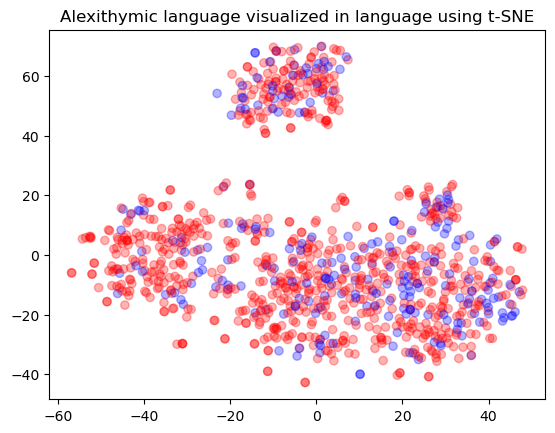

In [50]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = {'POSITIVE':'red', 'NEGATIVE':'blue'}
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = embeds_df['Alexithymia'].apply(lambda x: colors[x])

plt.scatter(x, y, c=color_indices, alpha=0.3)
plt.title("Alexithymic language visualized in language using t-SNE")